100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.4MB/s]


Epoch 1, Train Loss: 258.3254, Val Loss: 229.8286
  BCE: 258.3254, KLD: 355.8821, KL Weight: 0.00
Epoch 2, Train Loss: 231.6271, Val Loss: 228.3795
  BCE: 226.3330, KLD: 52.9409, KL Weight: 0.10
Epoch 3, Train Loss: 229.0359, Val Loss: 228.9741
  BCE: 221.4360, KLD: 37.9996, KL Weight: 0.20
Epoch 4, Train Loss: 229.7590, Val Loss: 230.6192
  BCE: 219.8511, KLD: 33.0262, KL Weight: 0.30
Epoch 5, Train Loss: 231.2638, Val Loss: 232.4476
  BCE: 219.4976, KLD: 29.4155, KL Weight: 0.40
Epoch 6, Train Loss: 232.8018, Val Loss: 234.2288
  BCE: 219.5566, KLD: 26.4904, KL Weight: 0.50
Epoch 7, Train Loss: 234.2192, Val Loss: 235.8108
  BCE: 219.8080, KLD: 24.0187, KL Weight: 0.60
Epoch 8, Train Loss: 235.6432, Val Loss: 237.4217
  BCE: 220.2498, KLD: 21.9906, KL Weight: 0.70
Epoch 9, Train Loss: 237.0905, Val Loss: 238.8438
  BCE: 220.8043, KLD: 20.3577, KL Weight: 0.80
Epoch 10, Train Loss: 238.3859, Val Loss: 239.8774
  BCE: 221.2764, KLD: 19.0105, KL Weight: 0.90
Epoch 11, Train Loss: 237.78

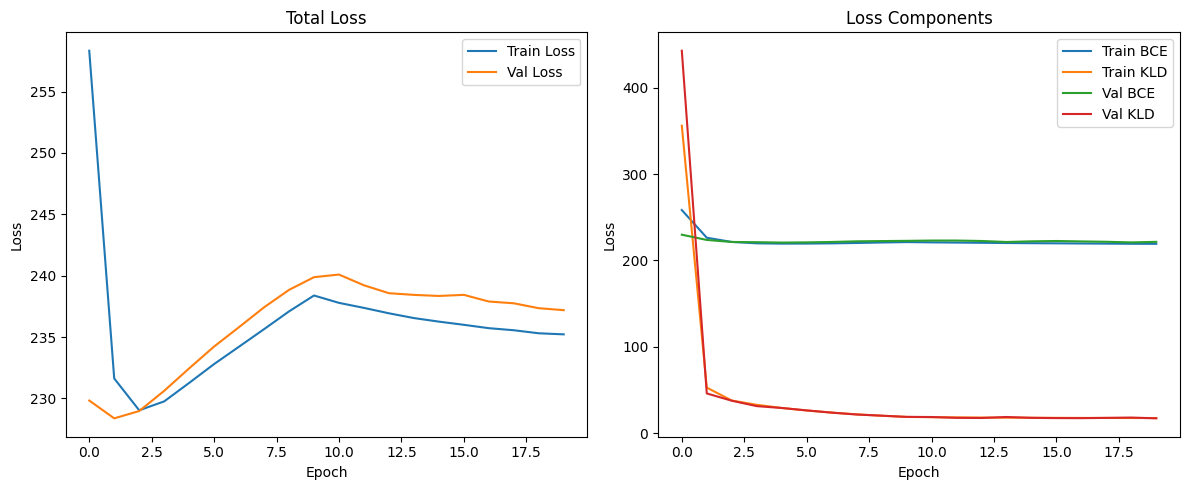


===== VISUALIZING RECONSTRUCTIONS =====


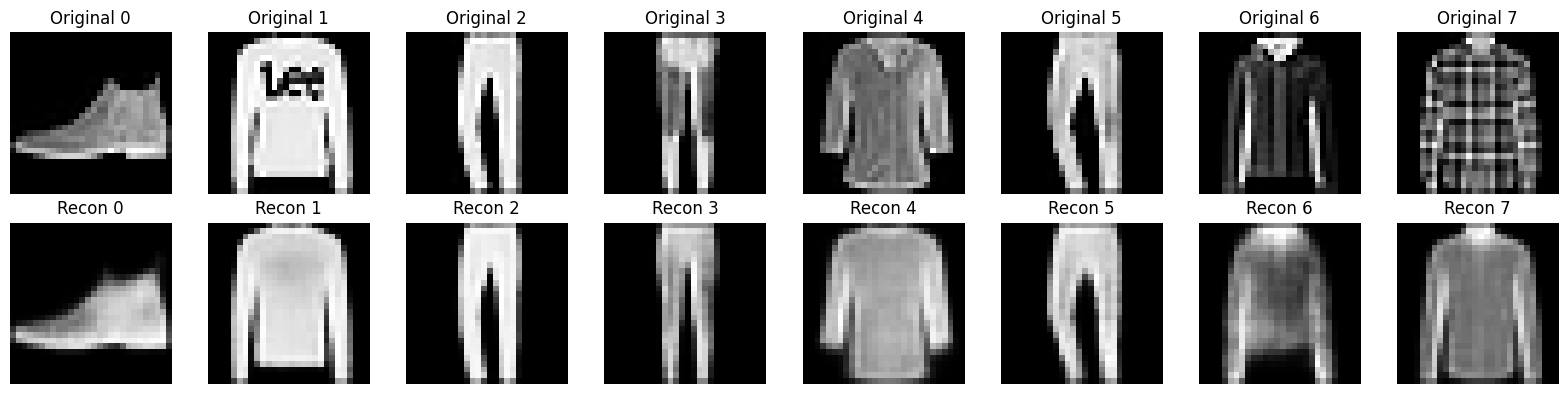


===== GENERATING SAMPLES FROM GAUSSIAN PRIOR =====


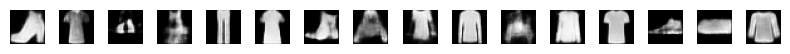


===== GENERATING SAMPLES FROM LAPLACIAN PRIOR =====


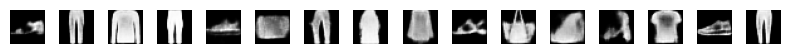


===== COMPARING DIFFERENT PRIORS =====


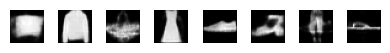

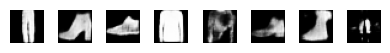

Gaussian prior samples std: 0.2797
Laplace prior samples std: 0.3636

===== ANALYZING POSTERIOR COLLAPSE =====
Average mean (μ): 0.0802
Average variance (σ²): 0.4478
Average KL divergence: 0.8172
No significant posterior collapse detected.


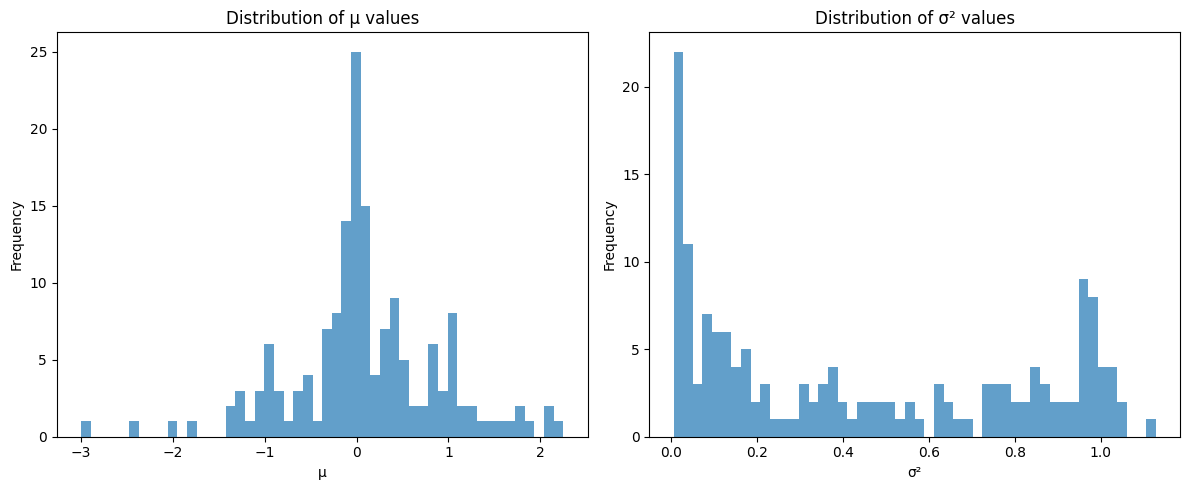


===== ANALYZING LOSS COMPONENTS =====
Final BCE: 219.2400
Final KLD: 17.7562
BCE/KLD ratio: 12.3472
Good balance between reconstruction and regularization terms.

===== MITIGATION STRATEGY ANALYSIS =====
We implemented KL annealing to mitigate posterior collapse:
- Started with KL weight = 0.0 to let the encoder learn meaningful representations
- Gradually increased KL weight to 1.0 over 10 epochs
- This allows the encoder to learn before the KL term is fully enforced

The strategy works because:
1. Early in training, the encoder can focus on learning good representations
2. Gradually introducing the KL term prevents it from overwhelming the reconstruction loss
3. This helps avoid the situation where the encoder learns to ignore inputs
4. The final model maintains a better balance between reconstruction and regularization

⚠️  Mitigation may need adjustment.
Consider tuning the annealing schedule or trying other strategies.

===== SUGGESTIONS FOR FURTHER EXPERIMENTS =====
To further i

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from architecture import VAE
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import laplace
import seaborn as sns

torch.manual_seed(42)
np.random.seed(42)

latent_dim = 20
batch_size = 128
epochs = 20
learning_rate = 1e-3

transform = transforms.ToTensor()
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def loss_function(recon_x, x, mu, logvar, kl_weight=1.0):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + kl_weight * KLD, BCE, KLD

train_losses, val_losses = [], []
train_bce_losses, train_kld_losses = [], []
val_bce_losses, val_kld_losses = [], []

kl_annealing_epochs = 10
kl_weight = 0.0  

for epoch in range(epochs):

    if epoch < kl_annealing_epochs:
        kl_weight = epoch / kl_annealing_epochs

    model.train()
    train_loss = 0
    train_bce = 0
    train_kld = 0

    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, bce, kld = loss_function(recon_batch, data, mu, logvar, kl_weight)
        loss.backward()
        train_loss += loss.item()
        train_bce += bce.item()
        train_kld += kld.item()
        optimizer.step()

    train_losses.append(train_loss / len(train_loader.dataset))
    train_bce_losses.append(train_bce / len(train_loader.dataset))
    train_kld_losses.append(train_kld / len(train_loader.dataset))

    model.eval()
    val_loss = 0
    val_bce = 0
    val_kld = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, bce, kld = loss_function(recon_batch, data, mu, logvar, kl_weight)
            val_loss += loss.item()
            val_bce += bce.item()
            val_kld += kld.item()

    val_losses.append(val_loss / len(test_loader.dataset))
    val_bce_losses.append(val_bce / len(test_loader.dataset))
    val_kld_losses.append(val_kld / len(test_loader.dataset))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
    print(f'  BCE: {train_bce_losses[-1]:.4f}, KLD: {train_kld_losses[-1]:.4f}, KL Weight: {kl_weight:.2f}')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_bce_losses, label='Train BCE')
plt.plot(train_kld_losses, label='Train KLD')
plt.plot(val_bce_losses, label='Val BCE')
plt.plot(val_kld_losses, label='Val KLD')
plt.title('Loss Components')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

def visualize_reconstructions(model, dataloader, num_samples=8):
    """Visualize original images and their reconstructions"""
    model.eval()
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images = images[:num_samples].to(device)

    with torch.no_grad():
        reconstructions, mu, logvar = model(images)

    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples*2, 4))

    for i in range(num_samples):
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].set_title(f'Original {i}')
        axes[0, i].axis('off')

        axes[1, i].imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
        axes[1, i].set_title(f'Recon {i}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.savefig('reconstructions.png')
    plt.show()

    return images, reconstructions, mu, logvar

def generate_samples(model, num_samples=16, prior='gaussian'):
    """Generate samples from the prior distribution"""
    model.eval()

    if prior == 'gaussian':
        z = torch.randn(num_samples, latent_dim).to(device)
    elif prior == 'laplacian':
        z = torch.tensor(
            laplace.rvs(size=(num_samples, latent_dim)),
            dtype=torch.float32
        ).to(device)
    else:
        raise ValueError("Prior must be 'gaussian' or 'laplacian'")

    with torch.no_grad():
        samples = model.decode(z)

    plt.figure(figsize=(num_samples/2, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(samples[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'generated_samples_{prior}.png')
    plt.show()

    return samples

def compare_priors(model):
    """Compare samples from Gaussian vs Laplace priors"""
    gaussian_samples = generate_samples(model, num_samples=8, prior='gaussian')
    laplace_samples = generate_samples(model, num_samples=8, prior='laplacian')

    gaussian_std = gaussian_samples.std().item()
    laplace_std = laplace_samples.std().item()

    print(f"Gaussian prior samples std: {gaussian_std:.4f}")
    print(f"Laplace prior samples std: {laplace_std:.4f}")

    return gaussian_samples, laplace_samples

def analyze_posterior_collapse(mu_values, logvar_values):
    """Analyze whether posterior collapse is occurring"""
    mu_np = mu_values.cpu().numpy()
    logvar_np = logvar_values.cpu().numpy()
    var_np = np.exp(logvar_np)

    avg_mu = np.mean(mu_np)
    avg_var = np.mean(var_np)
    avg_kl = 0.5 * np.mean(-logvar_np + var_np + mu_np**2 - 1)

    print(f"Average mean (μ): {avg_mu:.4f}")
    print(f"Average variance (σ²): {avg_var:.4f}")
    print(f"Average KL divergence: {avg_kl:.4f}")

    if avg_kl < 1.0 and abs(avg_var - 1.0) < 0.1:
        print("Warning: Possible posterior collapse detected!")
        print("The encoder is ignoring inputs and matching the prior too closely.")
    else:
        print("No significant posterior collapse detected.")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(mu_np.flatten(), bins=50, alpha=0.7)
    plt.title('Distribution of μ values')
    plt.xlabel('μ')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(var_np.flatten(), bins=50, alpha=0.7)
    plt.title('Distribution of σ² values')
    plt.xlabel('σ²')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.savefig('posterior_analysis.png')
    plt.show()

    return avg_kl, avg_var

